<a href=https://en.wikipedia.org/wiki/John_Horton_Conway>John Conway</a> recently passed away and I wanted to do something in homage.

More than a decade ago, I happened to pick up the book "Sphere Packings Lattices and Groups" by Conway and Sloane. The deep beauty and complexity of the mathematics of lattices took me completely by surprise. I'm not much of a group theorist but visualizing and trying to understand high dimensional structures is one of my lifelong passions. So in this post I'm going to spend some time playing with visualizations of high dimensional lattices.

<!-- END_TEASER -->


# What's a Lattice?

A <a href=https://en.wikipedia.org/wiki/Lattice_(group)>lattice</a> is "just" any regular array of points in space. To add a little mathematical rigor, a lattice generated by vectors $v_i \in \mathbb{R}^n$ is the collection of points which can be expressed as a linear combination of the generating vectors with integer coefficients. Lets call the generating matrix $V$ with row vectors $v_i$ and the associated lattice $L(V)$. The points in the lattice are all the points,

\begin{equation}
a_i \in \mathbb{z}
\sum a_i v_i = x \in {\rm L(V)} \\
\end{equation}

The simplest example of a lattice in any number of dimensions is just the set of n-tuples of integers $\mathbb{Z}^n$. In this case the generating mgarix can be chosen to be the identity matrix and in which case the coefficients $a_i$ are simply equal to the corresponding coordinates of the $x$ vectors.

Note however that for most non-trivial lattices the correspondence between lattice points $x$ and an integer "address" $(a_0, a_1, ... a_n) \in \mathbb{Z}^n$ is not necessarily one to one. For any really interesting lattice there will exist many many possible different integer "addresses" for any given lattice point. Likewise although there is only one lattice corresponding to any generating matrix $V$ there are many possible equivalent generating matrices.

## Lattices are Cryptographically Complex!

Lattices seem intuitively like "simple" structures. But completely counter to this intiution just about every question about lattices turns out to be breath takingly hard to answer. For example finding the closest lattice point $l \in {\rm L}$ to an arbitrary point $x \in \mathbb{R}^n$ turns out to be difficult enough to be the basis for <a href=https://en.wikipedia.org/wiki/Lattice-based_cryptography> lattice cryptography</a>. In fact lattice quantization is one of the front runner candidates for problems which are still cryptographically secure even when attacked by large quantum computers! 

As a corrolary to this difficulty it turns out to actually be extremely computationally difficult in general to find the set of points closest to the origin and even just  efficiently enumerating all the points inside of some radius is not the trivial matter you might naievely expect.

## Lattices are Useful!

Despite their apparent esoteric nature and the difficulty of snapping general points in $\mathbb{R}^n$ to their closest lattice point given a general lattice. For specific lattices there can be very efficient algorighms for doing this ("quantizing" as it is called). In fact there is a close correspondence between error correcting codes of fixed length and the theory of lattices. 

# Sampling Lattice Points

As a first step towards visualizing a lattice lets tackle the seemingly trivial task of the  enumeration of the points belonging to that lattice.

Ideally it would be nice if I could easily write a function which would take a specification of a lattice and some radius R and return a complete list of all the lattice points inside of that radius. But there are two problems with this in practice. The obvious problem is that for lattices of even fairly modest numbers of dimensions the number of lattice points inside of any given radius will be proportional to ${\rm R^D}$ and will become  burdensomely large very rapidly. 

But the problem is even worse than the $R^D$ scaling might lead you to believe. Remember that there is usually a many to one correspondence between the set of integer coefficients $\mathbb{Z}^D$ and a given lattice point. This means that even if there are only a small number of points to be enumerated (say oh, I don't know... 240 to pick a number at random) actually carrying out the search for those points in a naive way might require a huge amount of computation.

## Brute  Force Rejection Sampling

But lets start with a naive approach just for fun.
Lets just pick a whole mess of random integer coefficients and throw away any duplicate points or points don't meet some set of criteria (e.g. lie outside of our target radius).

In [1]:
import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from scipy.spatial import Voronoi, voronoi_plot_2d

import seaborn as sns
import pandas as pd
import scipy.spatial
import scipy.cluster.vq as vq

from matplotlib.collections import EllipseCollection

In [2]:
plt.rcParams.update(
    {
        "figure.figsize":(8, 8),
        "font.size":16,
    }
)

In [3]:
def sample_lattice(
    generator_matrix,
    coefficient_sampler,
    filter_func,
    n_draws,
):
    pts = set()
    for i in range(n_draws):
        n_i = coefficient_sampler()
        lat_pt = np.dot(generator_matrix, n_i)
        if filter_func(lat_pt):
            pts.add(tuple(lat_pt))
    return np.array(list(pts))

## Z2

As a sanity check we can start by sampling the integer lattice in 2 dimensions $\mathbb{Z}^n$. The generating matrix is just the identity matrix. From here on in I will call the $\mathbb{Z}^n$ lattices simply Zn. 

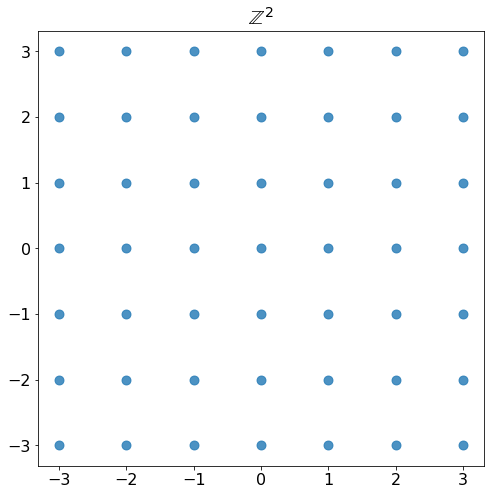

In [4]:
z2_generator = np.eye(2).astype(int)

pts_z2 = sample_lattice(
    z2_generator,
    coefficient_sampler = lambda : np.random.randint(-3, 3+1, (2,)),
    filter_func = lambda x: True,
    n_draws=1000,
)
plt.scatter(pts_z2[:, 0], pts_z2[:, 1], alpha=0.8, s=80);
plt.title("$\mathbb{Z}^2$", fontsize=20);

It is also easy to verify by eye that we have drawn enough samples to have gotten complete coverage of the region we are inspecting. For 2D lattices it is easy to draw enough samples to capture everything but for higher dimensional lattices it won't always be feasible to just up the sample count till we get everything. 

# Hex Lattice

One of my favorite lattices is what is often called the "hex" lattice. which has lots of nice properties. We can construct the hex lattice by using two generator vectors of unit length which make an angle of pi/3 with each other.

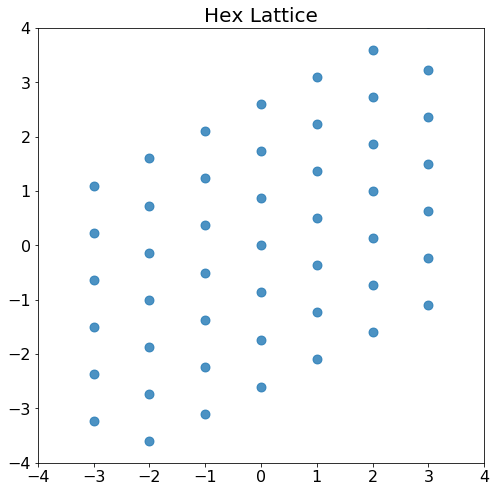

In [5]:
theta = np.pi/3
hex_generator = np.array([[1, 0], [np.cos(theta), np.sin(theta)]])

pts_hex = sample_lattice(
    hex_generator,
    coefficient_sampler = lambda : np.random.randint(-3, 3+1, (2,)),
    filter_func = lambda x: True,
    n_draws=1000,
)
plt.scatter(pts_hex[:, 0], pts_hex[:, 1], alpha=0.8, s=80)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.title("Hex Lattice", fontsize=20);

One thing you might immediately notice is that the square region of coefficients we are sampling in the integer coefficient space is getting mapped to a somewhat stretched out region. This effect will become more important later on in higher numbers of dimensions. 

Even though the regular integer lattice and this hex lattice may look somewhat similar they actually have rather different properties.
Notice that each point of the "square" lattice z2 has just 4 nearest neighbors, each point in the hex lattice has 6 points equidistant to it.

A wonderful trick helping visualize lattices in 2D is to visualize the Voronoi cells of the points. The Voronoi cell surrounding a point is the region closer to that point than to any other point in the point cloud. In 2D these are bounded by polygons which can be calculated and visualized without too much overhead. But in higher dimensions where the Voronoi cells become complex high dimensional polytopes they aren't quite so easy to deal with. 

But when you draw the Voronoi cells of each lattice it becomes clear that they do indeed have some very different properties.

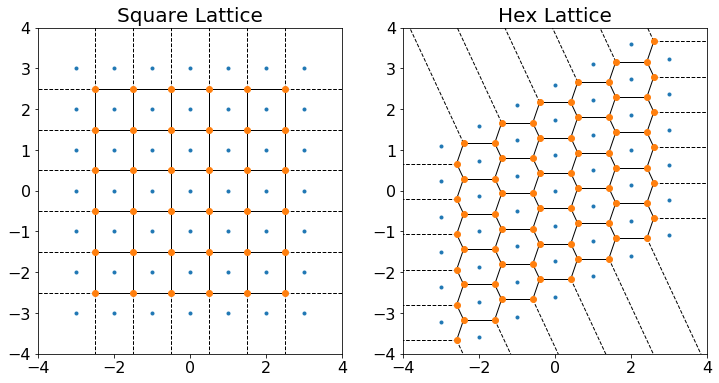

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
voronoi_plot_2d(Voronoi(pts_z2), ax=ax1)
voronoi_plot_2d(Voronoi(pts_hex), ax=ax2);
ax1.set_title("Square Lattice", fontsize=20);
ax2.set_title("Hex Lattice", fontsize=20);
ax1.set_xlim(-4, 4);
ax1.set_ylim(-4, 4);
ax2.set_xlim(-4, 4);
ax2.set_ylim(-4, 4);

# E8

Although there is plenty to be explored in the realms of 2 and 3 dimensional lattices I want to jump straight into the deep end and talk about a very special lattice called E8.

E8 is a very famous lattice (famous for a lattice anyway). <a href=https://en.wikipedia.org/wiki/E8_lattice> E8 lattice </a> is the densest way to pack equally spaced points in 8 dimensions. Similar to how in the 2D hex lattice each lattice point has 6 equidistant neighbors each point in the E8 lattice neighbors 240 other points. 

E8 is the unique optimum arrangement of points 8 dimensions by several metrics (such as sphere packing density) and is a particularly symmetric structure in 8 dimensions. Just as the hex lattice has more symmetries than the regular square lattice (e.g. 6 fold rotational symmetry vs 4 fold for the square lattice) the symmetry group of the E8 lattice is unusally large. Very symmetric sometimes also means very beautiful and certainly in the case of E8 this is true.

Visualizing the structure of E8 in any meaningful way is going to be much much harder than visualizing our 2D friends above but if we can get a sample of points to work with then we can use all the tools that one might normally apply to a high dimensional data set and see what happens. L

ets start by trying the same sampling trick that worked pretty well on the 2D lattices and see if we can get a representative sample of the points in E8 in the same way.

In [7]:
e8_generator = 0.5*np.array(
    [
        [4, -2,  0,  0,  0,  0,  0,  1],
        [0,  2, -2,  0,  0,  0,  0,  1],
        [0,  0,  2, -2,  0,  0,  0,  1],
        [0,  0,  0,  2, -2,  0,  0,  1],
        [0,  0,  0,  0,  2, -2,  0,  1],
        [0,  0,  0,  0,  0,  2, -2,  1],
        [0,  0,  0,  0,  0,  0,  2,  1],
        [0,  0,  0,  0,  0,  0,  0,  1],
    ]
)

In [8]:
pts_e8 = sample_lattice(
    e8_generator,
    coefficient_sampler = lambda : np.random.normal(-2, 2+1, (8,)),
    filter_func = lambda x: True,
    n_draws=10000,
)

I've bumped up the number of randomly sampled points from 1,000 to 10,000 since we will need many more points to fill up the 8 dimensional volume than we needed in 2D. Did we get a good representative sample of the lattice points near the origin? How can we tell?

In this particular case we happen to know that there are 240 vectors adjacent to the origin of squared norm equal to 2. So how many of these vectors did we capture in our 10,000 random draws?

In [9]:
e8_r_squared = np.sum(pts_e8**2, axis=1)

np.sum(np.abs(e8_r_squared - 2) < 0.0001)

0

Ouch, in our 10,000 samples we certainly haven't caught what could be considered a representative sample of the 240 points we know are nearest the origin.

Although we could simply bump up the number of random samples being drawn until we capture everything I would rather we start sampling smarter rather than just throwing more brute force computation at the problem. Especially since I don't even know how to clearly estimate what the appropriate range of integer coefficients I should be sampling over is. I might need to sample coefficients from -100 to 100 in order to get all the points nearest the origin for all I know. 

# Roughly  Spherical Sampling

A big part of the problem here is that the way that we are choosing the integer coefficients is not very well matched to the distribution of coefficients for the points centered on the origin. This manifested itself earlier as the apparent stretching of the hex lattice relative to the square lattice. In 2 dimensions this effect was tolerable if annoying, but in 8 dimensions the problem has become much worse.

We can see just how bad things are by running our sampled E8 lattice points through a PCA expansion and taking a look at roughly how spherically symmetrically distributed our poins are. A perfectly spherically symmetric distribution would assign equal variance to each dimension and the e8 lattice is invariant to permutations of the 8 dimensions so any complete sample of lattice points inside some radius will have a flat variance plot.

In [10]:
def cumulative_variance_plot(pts):
    pca = PCA().fit(pts)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    captured_variance = pca.explained_variance_ratio_
    ax = axes[0]
    ax.plot(np.arange(1, pts.shape[1]+1), captured_variance)
    ax.axhline(0, linestyle="--", color="k")
    ax.set_xlabel("Principal Direction")
    ax.set_ylabel("Projected Variance");

    ax = axes[1]
    ax.plot(np.arange(1, pts.shape[1]+1), np.cumsum(captured_variance))
    ax.axhline(0, linestyle="--", color="k")
    ax.set_xlabel("Principal Direction")
    ax.set_ylabel("Cumulative Captured Variance");

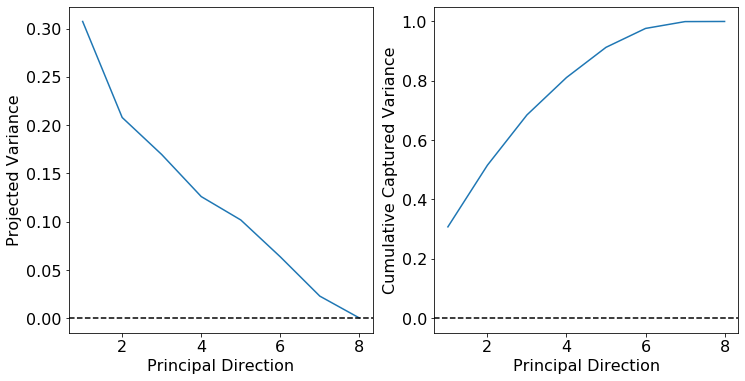

In [11]:
cumulative_variance_plot(pts_e8)

Ouch, not only is the variance plot not flat, but our samples are practically not even fully 8 dimensional. Our sampling method is overwhelmingly sampling points from a thin 3 or 4 dimensional hyper plane. With hardly any points being sampled outside of this thin subspace. 

The culprit is the same stretching out we saw when looking at the distribution of sampled points for the hex lattice. 
The vectors in the generator matrix are far from orthogonal so vectors chosen with spherically symmetric coefficients will get distorted into an oblong shape oriented along special directions along which the vectors of our generator matrix tend to point.

In order to calculate these special directions we can interpret the  <a href=https://en.wikipedia.org/wiki/Gramian_matrix#Gram_determinant>gram matrix</a> of the generating matrix as a covariance matrix. 

The gram matrix of the generator matrix is equal to the covariance matrix of the multivariate normal distribution which would result if you transform a spherically distributed normal distribution in 8 dimensions by multiplication by the E8 generator basis. 

As confirmation we can check that the projected variance along each dimension of the principal component expansion is closely matched to the eigenvalues of the grammian of the generator matrix (the differences being due to finite sample size).

In [12]:
pca = PCA().fit(pts_e8)
generator_grammian = np.dot(e8_generator.transpose(), e8_generator)
eig_vals = np.linalg.eigh(generator_grammian)[0][::-1]
np.max(np.abs(eig_vals/np.sum(eig_vals) - pca.explained_variance_ratio_))

0.0018053837235108006

## A Slightly Smarter Sampling Method

So, Instead of sampling points in E8 roughly spherically symmetrically like we want we are actually sampling vectors which are easy to express as as sums of small integer multiples of the generating vectors and that turns out to not at all be the same thing. 

We can roughly adjust for this bias by sampling from a distribution which is designed to cancel out the stretching process caused by multiplication by our generating matrix to give us something spherically symmetric. 

Since multiplication of our coefficient terms by the generator matrix is stretching out our distributions along directions and amounts determined by the eigen vectors and eigen values of the grammian matrix. We can roughly cancel out this stretching by sampling our coefficient vectors from a distribution which has a covariance matrix proportional to the inverse of the grammian.

In [13]:
from matplotlib.colors import LinearSegmentedColormap
clist = [(0.1, 0.6, 1.0), (0.05, 0.05, 0.05), (0.8, 0.5, 0.1)]
bublor_cmap = LinearSegmentedColormap.from_list("bublor", clist)

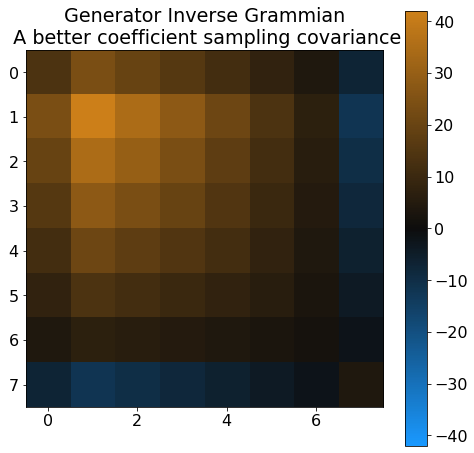

In [14]:
gram_matrix = np.dot(e8_generator.transpose(), e8_generator)
inv_grammian = np.linalg.inv(gram_matrix)
vmax = np.max(np.abs(inv_grammian))
plt.imshow(
    inv_grammian,
    cmap=bublor_cmap,
    vmin=-vmax,
    vmax=vmax,
)
plt.colorbar()
plt.title("Generator Inverse Grammian\n A better coefficient sampling covariance");

Our initial integer coefficient sampling density had a covariance matrix which was essentially diagonal. So that the coefficient we attach to the first generator vector had almost no correlation with the coefficient we attach to the second vector in the generator matrix and so on. Each coefficient was simply chosen independently of the others in a range from -m to +m for some small m. Hoping that this would give us a good sampling of the lattice.

Interpreting the inverse grammian of our generator matrix above as a covariance matrix we see that actually what we should have been doing is picking our coefficients which are highly positively correlated with each other for the first 7 generating vectors and weakly negatively correlated with the coefficient for the final generating vector. 

Lets encode this intuition into a helper function which takes a generator matrix and an overall scale and gives us back a random coefficient sampling function which is well matched to the structure of our generator.

In [15]:
def make_matched_sampler(generator, scale):
    grammian = np.dot(generator.transpose(), generator)
    determinant = np.linalg.det(grammian)
    #force determinant one
    grammian = grammian/determinant
    inv_grammian = np.linalg.inv(grammian)
    n_dim = len(inv_grammian)
    return lambda : np.around(scale*np.random.multivariate_normal(np.zeros(n_dim), inv_grammian)).astype(int)

In [16]:
csampler = make_matched_sampler(e8_generator, 1.0)

In [17]:
csampler()

array([ 1,  1,  1,  1,  0,  1,  0, -1])

In [18]:
pts_e8 = sample_lattice(
    e8_generator,
    coefficient_sampler = csampler,
    filter_func = lambda x: True,
    n_draws=10000,
)

In [19]:
e8_r_squared = np.sum(pts_e8**2, axis=1)

np.sum(np.abs(e8_r_squared - 2) < 0.0001)

172

 That is much much better, with the same 10,000 points we are getting a majority of the 240 points of minimal norm now. 
 
 Lets take a look at the projected variance in each dimension and see if we are getting rough spherical symmetry in our sampling.

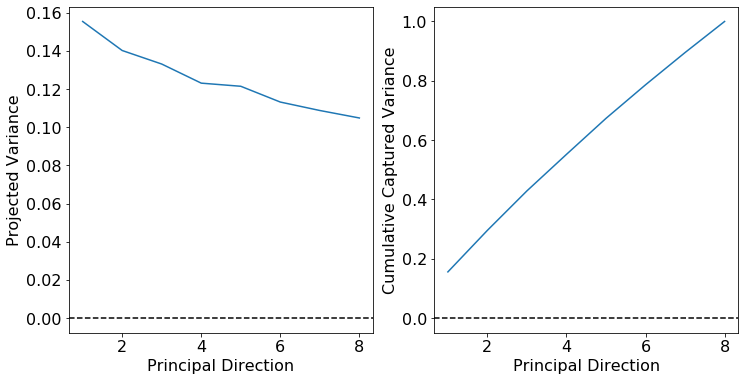

In [20]:
cumulative_variance_plot(pts_e8)

Much better! With the same 10,000 sample points we explore a fully 8 dimensional subspace with very little asymmetry.

## Vectors of Minimal Norm

Every point in E8 has exactly 240 neighbors which are arranged exactly the same way as the 240 points adjacent to the origin. Every lattice consists of some such regular shape tesselated over its covering space. Lets collect those vectors of minimal norm for E8 and try to visualize the resulting shape as best we can.

In [21]:
e8_root = sample_lattice(
    e8_generator,
    coefficient_sampler = make_matched_sampler(e8_generator, 0.8),
    filter_func = lambda x: np.abs(np.sum(x**2) - 2.0) < 0.01,
    n_draws=20000,
)

In [22]:
#240 neighbors + the origin
assert 240 == len(e8_root)

I want to emphasize how much more efficient this is than the hyper cube sampling. For the particular set of generator vectors we used some of the minimal norm vectors of the lattice have integer coefficients as large as +/-7. A complete enumeration of all of the possible length 8 integer vectors up to maximum magnitude of 7 would have required sampling more than 2 billion lattice points! Clearly enumeration over a grid of all possible small integer coefficients isn't a good search strategy.

In [23]:
(2*7+1)**8

2562890625

# Visualizing E8 

Visualizing structures in more than two dimensions can be pretty difficult. This is especially true for structures which are irreducibly high dimensional. Where it is very hard to capture much of the structure in a 2 or 3 dimensional slice of the data. 

E8 can only exist in 8 or more dimensions and although 8 columns isn't terribly high dimensionality as far as datasets go, but, in this case the structure is so complex that in many ways it is much more difficult to analyze than lots of datasets with dozens of mostly independent features. 

Lets start where I would likely start the visualization of any data set with 8 columns and make a pairwise scatter plot. These sorts of plots can be great for telling you when two features of a dataset have some sort of strong correlation with each other and often can reveal more subtle types of interactions as well. 

However, as you can see below, these types of pairwise grids aren't really fantastic for understanding relationships which are irreducibly high dimensional.

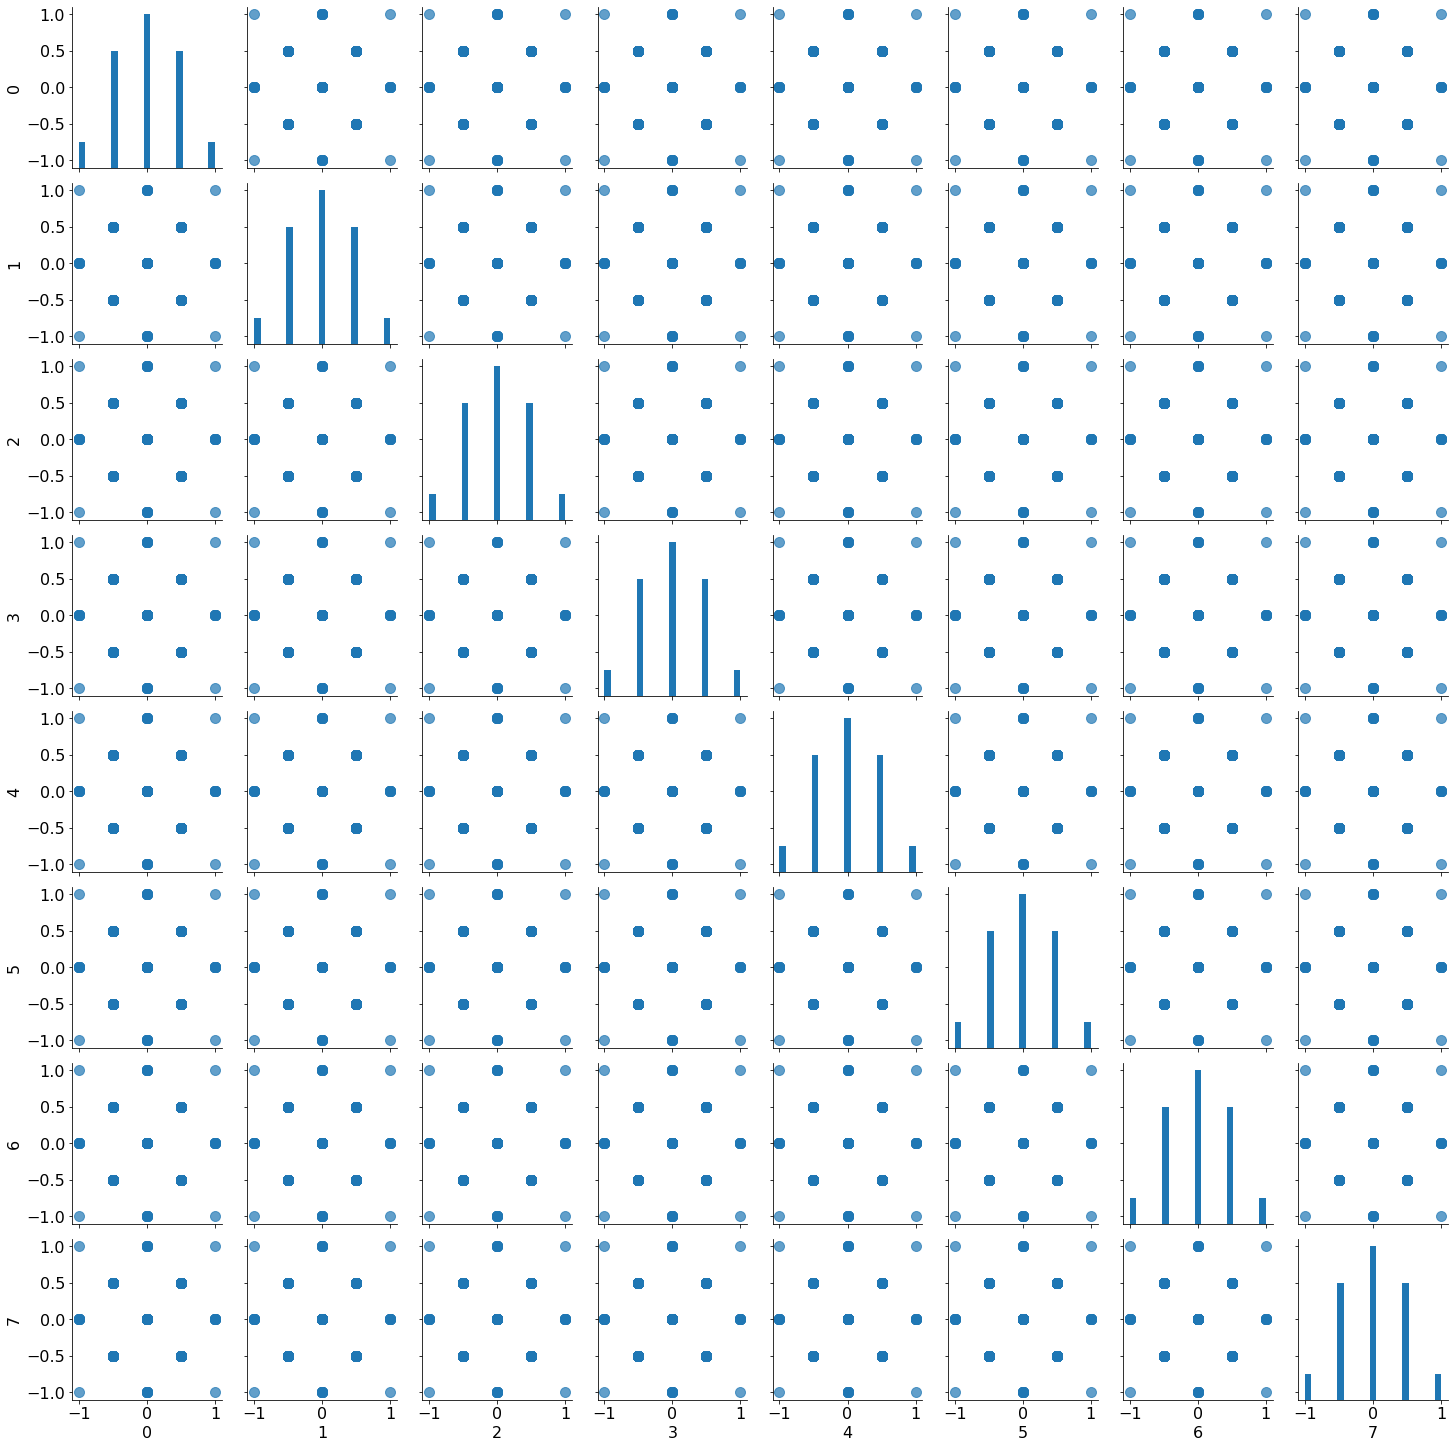

In [24]:
g = sns.PairGrid(pd.DataFrame(e8_root))
g.map_offdiag(plt.scatter, s=100, alpha=0.7)
g.map_diag(plt.hist, bins=21)

for ax in g.axes.ravel():
    #ax.axis("off")
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)

From taking a look at that you might be tempted to think that actually E8 has a very simple structure. It is actually true that for E8 any permutation of the axes leaves the resulting distribution of points unchanged. You might mistake this property as saying that E8 will look more or less the same no matter what perspective you look at it from but you would be wrong. We have just happened to pick about the most boring possible set of perspectives we could possibly have done.

Lets do a pairwise grid plot again but this time lets first apply a random rotation first so that we are really seeing the data from a set of random perspectives.

In [25]:
def random_rotation_matrix(D):
    "generate a random rotation matrix in D dimensions"
    q, _ = np.linalg.qr(np.random.normal(size=(D, D), ))
    return q

In [26]:
np.random.seed(89)
u = np.dot(e8_root, random_rotation_matrix(8))

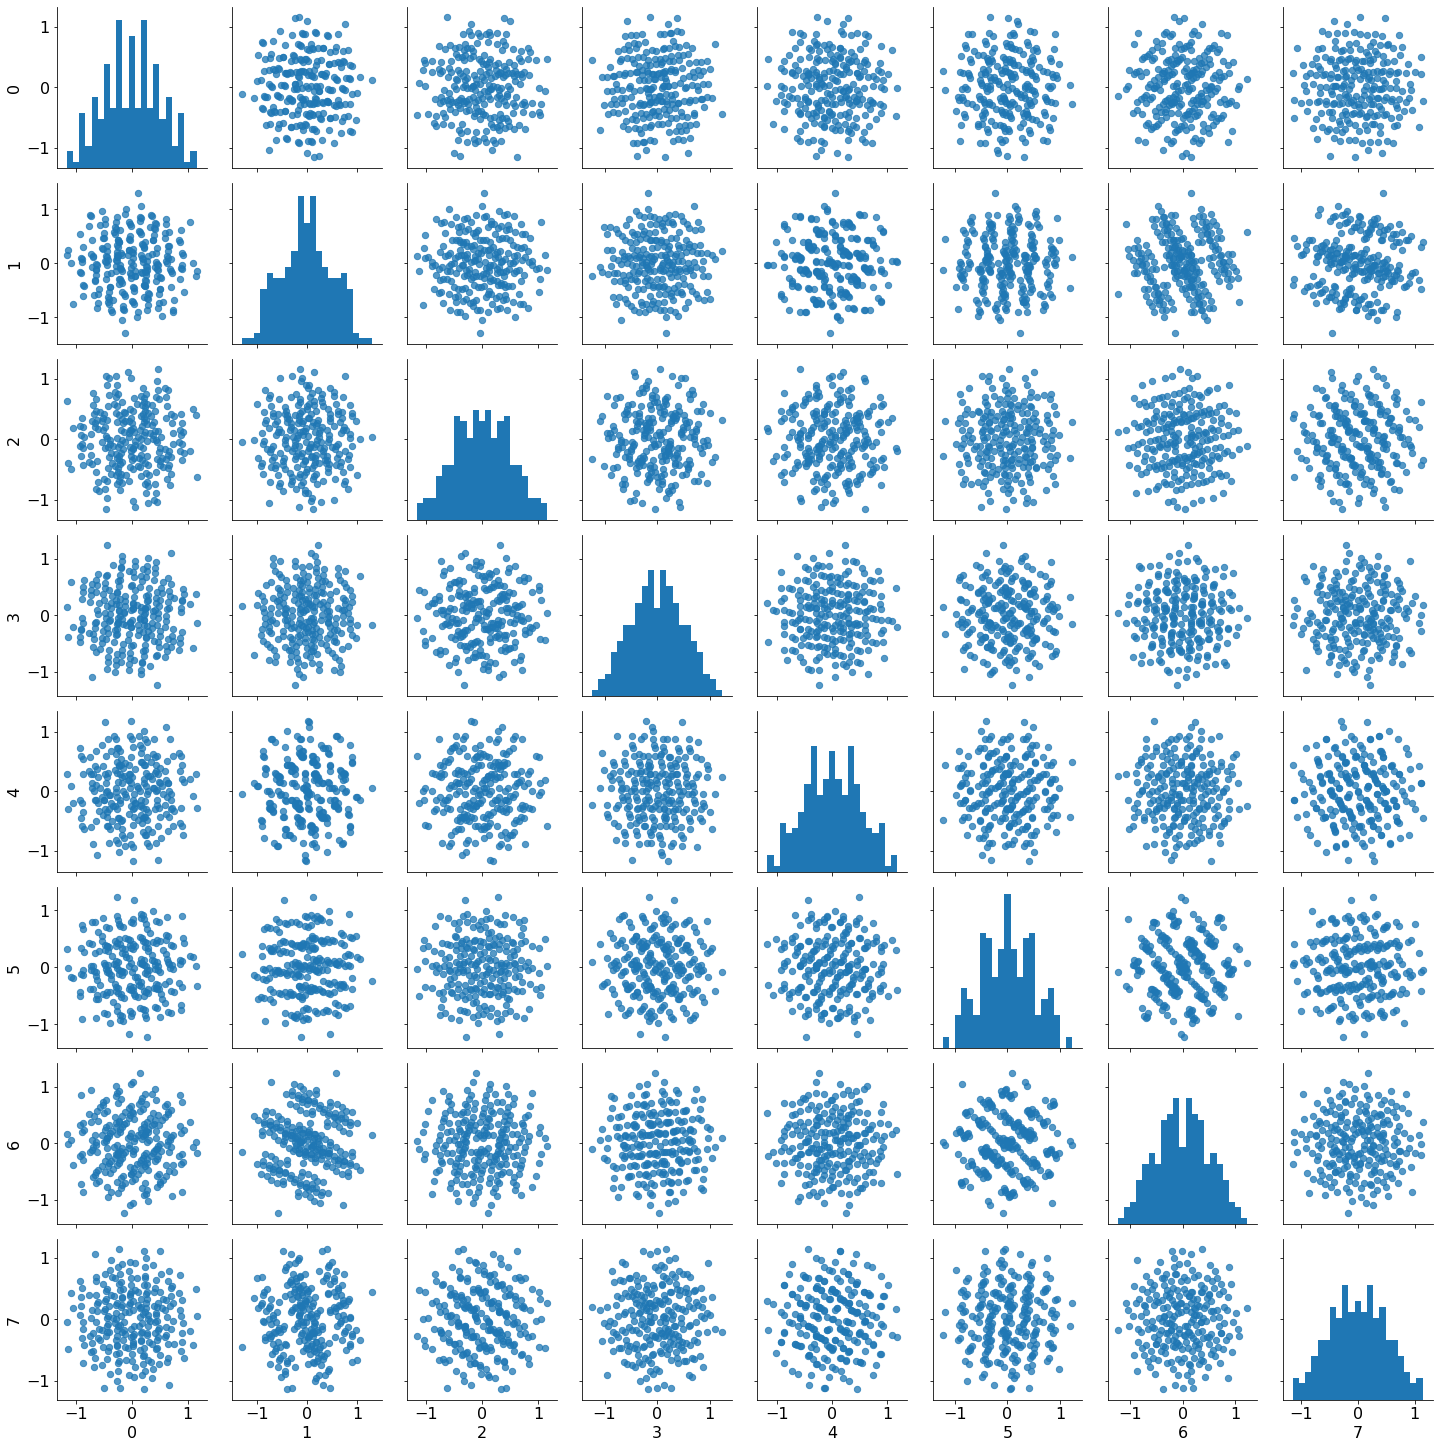

In [27]:
g = sns.PairGrid(pd.DataFrame(u))
g.map_offdiag(plt.scatter, s=40, alpha=0.75)
g.map_diag(plt.hist, bins=21)

That's quite a bit more interesting. Some of these perspectives look like random blobs some look like planes of points from an oblique perspective. Some plots have apparent "clumpiness" and some look like some very symmetric structure plus a little random noise.

# A Search For Interesting Perspectives

Some of these perspectives are much more visually striking than others. Having seen a few very striking visualizations of E8 like those in this <a href="https://www.youtube.com/watch?v=y-Gk_Ddhr0M">ted talk</a> I know that there are a number of very interesting looking projections which are possible to find (skip to around the 7 minute mark in that video if you just want to see the visualizations). 

I don't want to delve into any deep group theory here, I just want to make some pretty pictures. To capitalize on my strengths I am going to try to reformulate the question of finding "interesting" projections of E8 as an optimization problem. If I can figure out how to write out an "interestingness" metric for different projections as a python function then I can do a search over the space of possible projections to find some pretty gems to share.

## Smoothly Parameterizing The Space of Rotation Matrices

Ultimately I am headed towards making animations of E8 as it rotates around in 8D. 
It turns out that rotation matrices in any number of dimensions can be expressed as the matrix exponential of skew symmetric matrices. A skew symmetric matrix is a matrix A such that the transpose of the matrix is equal to -1 times itself.

$$A^{\rm T} = -A$$

Again I'm not much of a group theorist but I think that all possible rotation matrices are expressable as the matrix exponential of a skew symmetric matrix and defininitely all matrix exponentials of skew symmetric matrices are rotation matrices (meaning that $Exp(A)^T = Exp(A)^{-1}$ or equivalently $Exp(A)^T Exp(A) = I$ )

In [28]:
def vector_to_skew_matrix(
    param_vec,
    n_dims,
):
    assert len(param_vec) == n_dims*(n_dims-1)//2
    pvecs = []
    lb = 0
    
    #build up the upper triangular component of the matrix
    for i in range(n_dims):
        front_padding = i+1
        n_params = n_dims-front_padding
        cvec = np.hstack([np.zeros(front_padding), param_vec[lb:lb+n_params]])
        pvecs.append(cvec)
        lb += n_params
    
    #subtract off the transpose of the matrix from itself 
    sks = np.vstack(pvecs)
    sks = sks - sks.transpose()
    return sks

In [29]:
A = vector_to_skew_matrix(np.random.randint(-10, 10, size=28,), 8)
A

array([[ 0., -6., -8.,  9.,  5., -2.,  6., -6.],
       [ 6.,  0.,  7., -4., -9.,  5., -6., -9.],
       [ 8., -7.,  0., -7., -2., -3., -1., -1.],
       [-9.,  4.,  7.,  0.,  0.,  2.,  7.,  0.],
       [-5.,  9.,  2.,  0.,  0., -1., -3., -1.],
       [ 2., -5.,  3., -2.,  1.,  0., -6.,  6.],
       [-6.,  6.,  1., -7.,  3.,  6.,  0.,  6.],
       [ 6.,  9.,  1.,  0.,  1., -6., -6.,  0.]])

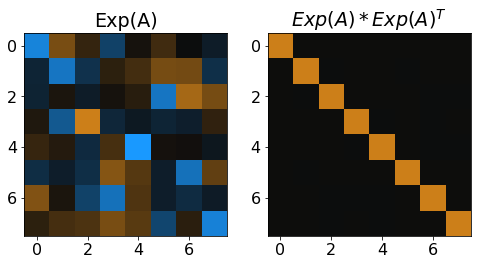

In [30]:
rmat = scipy.linalg.expm(A)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(rmat, cmap=bublor_cmap)
axes[0].set_title("Exp(A)")

axes[1].imshow(np.dot(rmat, rmat.transpose()), cmap=bublor_cmap, vmin=-1, vmax=1)
axes[1].set_title("$Exp(A)*Exp(A)^T$");

## A Search Metric

There is no way to encode the abstract idea "looks interesting" into a quick to execute python function. I tried out a number of different sorts of fitness functions; the distance between the nearest two points in projection, mean in plane radius of the projected points, the average over distances in small neighborhoods, etc. 

What ultimately worked best was to break the points into a fixed number of circular shells and then use some statistic about the distribution of radii of the points in those shells.

Below are some hand picked random seeds and metric parameters which happened to give interesting 2D projections.

In [31]:
class RadialShellCost(object):
    
    def __init__(
        self,
        pts,
        n_shells,
        cost_aggregator,
        kmeans_fn=vq.kmeans2,
    ):
        self.pts = pts
        self.n_shells = n_shells
        self.cost_aggregator=cost_aggregator
        self.kmeans_fn=kmeans_fn
        
    def __call__(self, params):
        cost = 0
        
        sks_mat = vector_to_skew_matrix(params, n_dims=self.pts.shape[1])
        rmat = scipy.linalg.expm(sks_mat)

        projection_vectors = rmat[:, :2]
        projected_pts = np.dot(self.pts, projection_vectors)
        radii = np.sqrt(np.sum(projected_pts**2, axis=1))

        shell_radii, _ = self.kmeans_fn(radii, self.n_shells)
        shell_assignment, off_shell = vq.vq(radii, shell_radii)
        
        cost += np.sum(off_shell**2)

        return cost
    

In [32]:
interesting_perspectives = [
    dict(
        random_seed = 1,
        start_vector="random",
        cost_fn=RadialShellCost(
            pts=e8_root,
            n_shells=1,
            cost_aggregator=lambda d: np.sum(d**2),
        ),
        final_vector=None,
    ),
    dict(
        random_seed = 19,
        start_vector= "random",
        cost_fn=RadialShellCost(
            pts=e8_root,
            n_shells=2,
            cost_aggregator=lambda d: np.sum(d**2),
            kmeans_fn=vq.kmeans,
        ),
        final_vector=None,
    ),
    dict(
        random_seed = 10,
        start_vector= "random",
        cost_fn=RadialShellCost(
            pts=e8_root,
            n_shells=2,
            cost_aggregator=lambda d: np.sum(d**2),
            kmeans_fn=vq.kmeans2, 
        ),
        final_vector=None,
    ),    
    dict(
        random_seed = 16,
        start_vector= "random",
        cost_fn=RadialShellCost(
            pts=e8_root,
            n_shells=2,
            cost_aggregator=lambda d: np.sum(d**2),
            kmeans_fn=vq.kmeans, 
        ),
        final_vector=None,
    ),
    dict(
        random_seed = 5,
        start_vector= "random",
        cost_fn=RadialShellCost(
            pts=e8_root,
            n_shells=3,
            cost_aggregator=lambda d: np.sum(d),
            kmeans_fn=vq.kmeans,
        ),
        final_vector=None,
    ),
    dict(
        random_seed = 1,
        start_vector= "random",
        cost_fn=RadialShellCost(
            pts=e8_root,
            n_shells=2,
            cost_aggregator=lambda d: np.sum(d**2),
            kmeans_fn=vq.kmeans,
        ),
        final_vector=None,
    ),
    dict(
        final_vector=np.zeros(28) #the identity transform
    ),
]

Optimization terminated successfully.
         Current function value: 18.284103
         Iterations: 2696
         Function evaluations: 3440


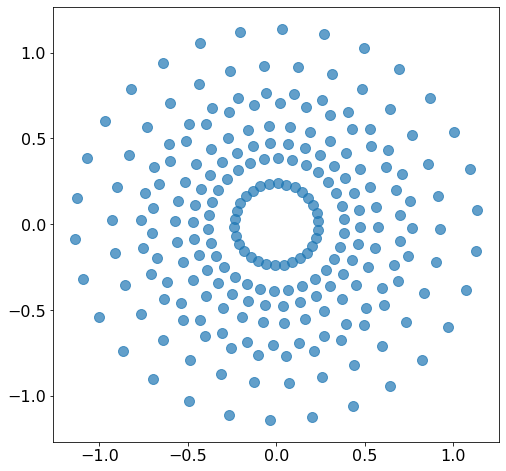

Optimization terminated successfully.
         Current function value: 2.067037
         Iterations: 1946
         Function evaluations: 2512


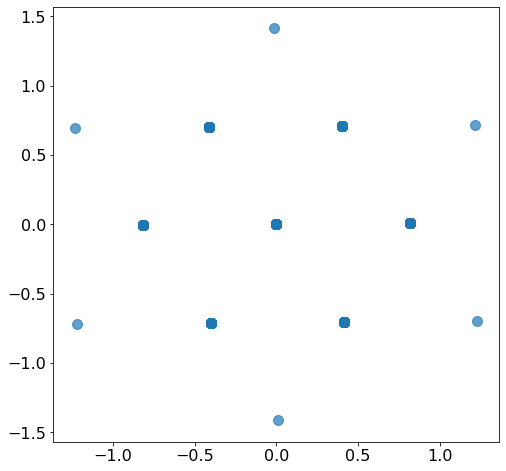

/home/tim/anaconda3/lib/python3.7/site-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


Optimization terminated successfully.
         Current function value: 5.010035
         Iterations: 1824
         Function evaluations: 2393


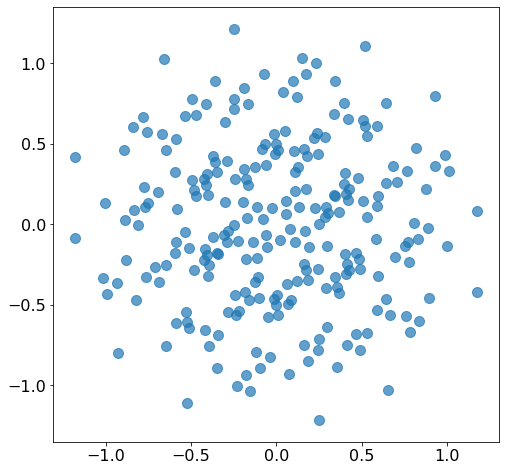

Optimization terminated successfully.
         Current function value: 5.137027
         Iterations: 1688
         Function evaluations: 2202


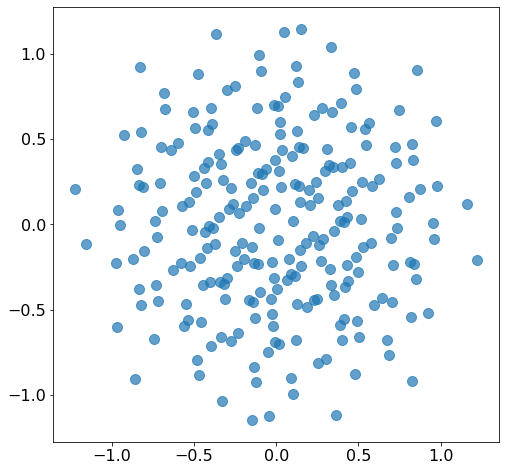

Optimization terminated successfully.
         Current function value: 2.058130
         Iterations: 1379
         Function evaluations: 1834


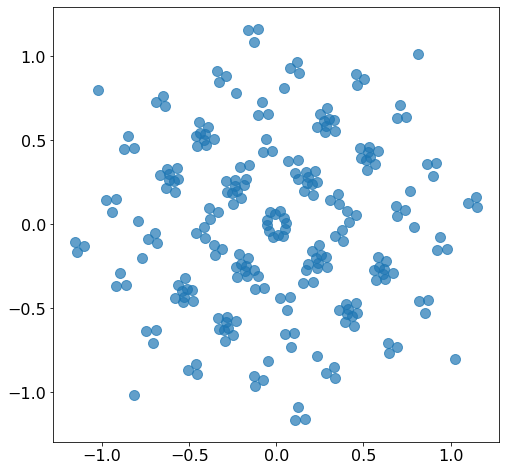

Optimization terminated successfully.
         Current function value: 4.987419
         Iterations: 2631
         Function evaluations: 3312


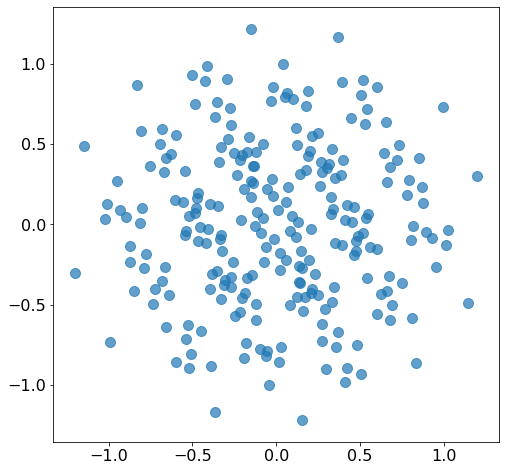

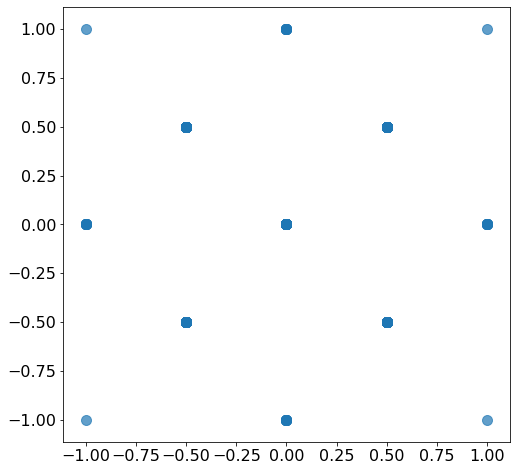

In [33]:
for persp in interesting_perspectives:
    if persp["final_vector"] is None:
        np.random.seed(persp["random_seed"])
        start_vector = persp["start_vector"]
        if isinstance(start_vector, str) and start_vector == "random":
            x0 = np.random.normal(size=28)
        else:
            x0 = persp["start_vector"]
        rot_params = scipy.optimize.fmin(
            persp["cost_fn"],
            x0=x0,
            maxiter=10000,
        )
        persp["final_vector"] = rot_params
    else:
        rot_params = persp["final_vector"]

    rmat = scipy.linalg.expm(
        vector_to_skew_matrix(rot_params, 8)
    )

    u = np.dot(e8_root, rmat)
    plt.scatter(u[:, 0], u[:, 1], alpha=0.7, s=100)
    plt.show()

# Animation

The above perspectives certainly give a sense of how impressively different E8 can look depending on the particular 2D projection you pick. But these representations in isolation can't give you much of a sense for how these very different looking structures relate to each other. Since you can't just take an 8 dimensional E8 polytope and turn it around in your hand I want to try to get the next best thing and create a moving animation which takes you on a tour of various representations of E8 in a continuous way.

As you will see below I was using colored ellipses with an edge color as my base glyphs to represent each point. This puts a ceiling of 11 total degrees of freedom per point. Each ellipse has an x, y, length, width, angle, and a face color. Which makes 6 degrees of freedom, and each ellipse optionally can be outlined in a line with a different edge color. If you are mapping the face color and the edge color via a 1D color map (like you really should) then that makes the representation 7 dimensional. But if you are feeling bold you can treat each of the red, green, and blue channels of the point color as independently controlled aspects of the point glyphs in which case each of the two colors can be thought of as a 3 dimensional design space which brings us up to 11.

In the end though 11 dynamically changing aspects of each point turned out to just be a lot of visual clutter and keeping the number of dynamically mapped aspects of the visualization down to just the 2 coordinates of the scatter plot ended up being the thing that was most visually appealing and which most faithfully represents the underlying structure. Mapping all 3  color channels at once dynamically helps you see the structure in some cases but because that also changes the contrast of the points with the background and their visual saliency it adds more visual noise than it adds visually parsable structure. The same goes for the various mappings of size and shape of the points. There may be more information on the screen but it all just parses to my visual cortex as chaos not structure. Not to mention I could never get the shape parameters for the ellipses to update properly so I may also have some ulterior motives for dropping that aspect of the visualization...

The animations that I ended up have just the 2 dynamically mapped spatial coordinates and everything else is kept fixed.

## Adding a Little Color

Instead of mapping the colors of points dynamically I found it is much more helpful to use the color as a way to identify the points and ground your understanding of a representation which stays constant accross perspectives. So we need a way to assign each point a unique coloration. In principle any random coloration could work but a completely random coloration is not very informative. It would be nice if each point was colored in a way that says something meaningful about it.

Although I don't have any proofI think that the 2D projection above which consists of concentric circular shells is actually the coxeter plane <a href=https://en.wikipedia.org/wiki/Coxeter_element>coxeter plane</a>. 

A somewhat natural way to map these points to colors is to use their position within the Coxeter plane. I've decided to map the overall brightness to radius and the angle to hue.

To maximize the color contrast I put the points on a dark background and in order to make all points stand out equally well from that dark background I will surround the points in an edge color whose hue is complementary to the face color hue but whose lightness is set to a fixed value to make a roughly constant background contrast.

I hope you will agree the resulting colors are rather nice.

In [34]:
import colorsys

#color complement calculation grabbed from stack overflow
#https://stackoverflow.com/questions/40233986/python-is-there-a-function-or-formula-to-find-the-complementary-colour-of-a-rgb

# Sum of the min & max of (a, b, c)
def hilo(a, b, c):
    if c < b: b, c = c, b
    if b < a: a, b = b, a
    if c < b: b, c = c, b
    return a + c

def complement_color(r, g, b):
    k = hilo(r, g, b)
    return tuple(k - u for u in (r, g, b))


coxeter_rmat = scipy.linalg.expm(
    vector_to_skew_matrix(
        interesting_perspectives[0]["final_vector"],
        8
    )
)

x,y = np.dot(e8_root, coxeter_rmat)[:, :2].transpose()
radii = np.sqrt(x**2+y**2)
angles = np.arctan2(y, x)

normed_r = radii/np.max(radii)
normed_angles = (angles-np.min(angles))/(np.max(angles)-np.min(angles))

rgb_triplets = []
complements = []

for angle, normed_radius in zip(angles, normed_r):
    angle_01 = (angle+np.pi)/(2*np.pi)
    crgb = colorsys.hls_to_rgb(angle_01, 0.1+0.7*normed_radius, 1.0)
    rgb_triplets.append(crgb)
    complement_rgb=complement_color(*crgb)
    ch, cl, cs = colorsys.rgb_to_hls(*complement_rgb)
    complements.append(colorsys.hls_to_rgb(ch, 0.5*(cl-0.5)+0.7, cs))


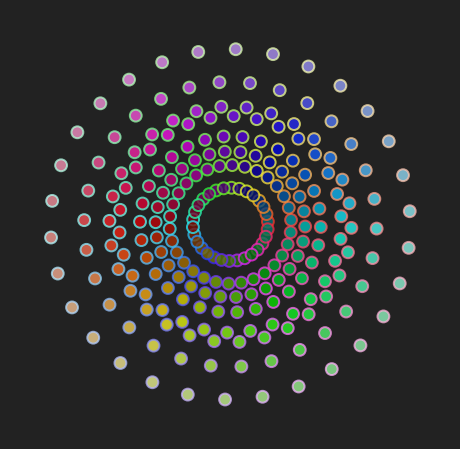

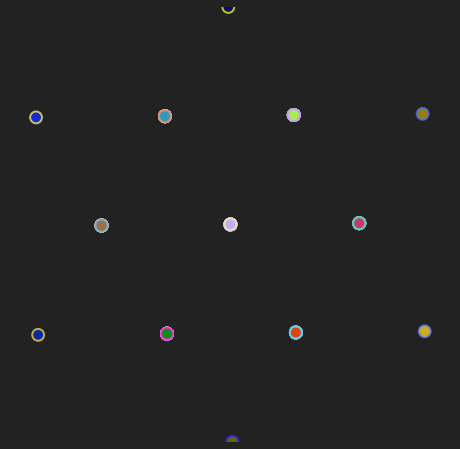

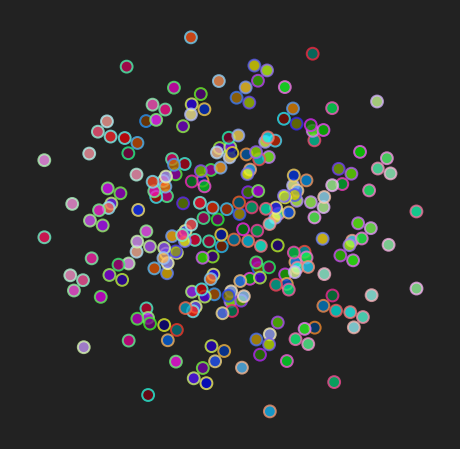

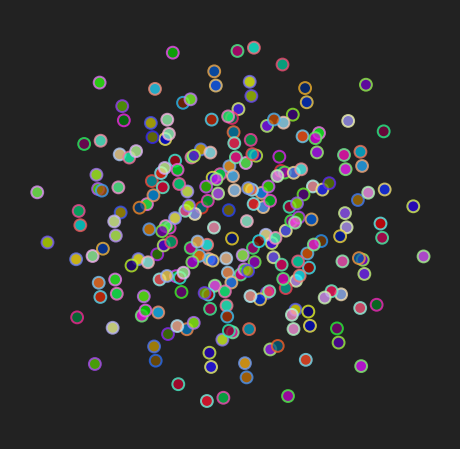

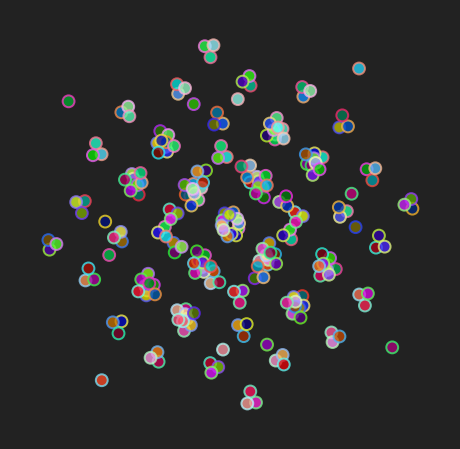

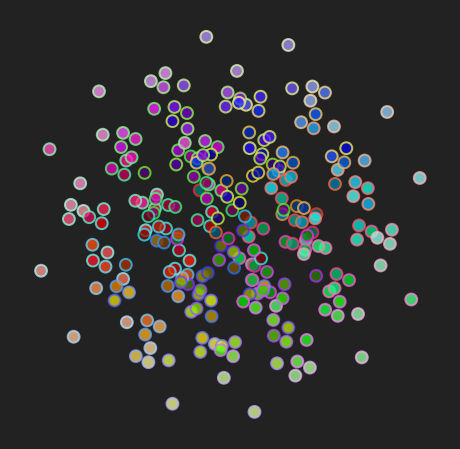

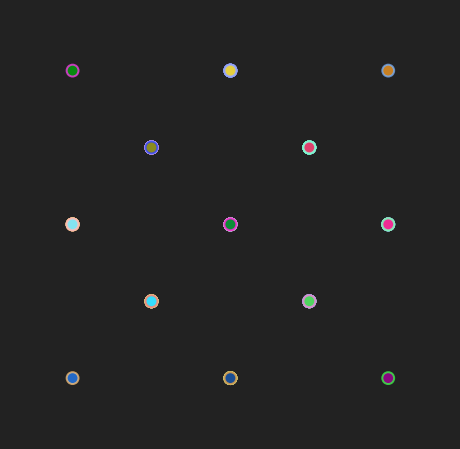

In [35]:
for i in range(len(interesting_perspectives)):
    rmat = scipy.linalg.expm(
        vector_to_skew_matrix(interesting_perspectives[i]["final_vector"], 8)
    )
    u = np.dot(e8_root, rmat)

    fig, ax = plt.subplots()
    fig.set_facecolor("#222222")
    ax.axis("off")

    rt2 = np.sqrt(2)
    ax.set_xlim(-rt2, rt2)
    ax.set_ylim(-rt2, rt2)

    u01 = (u+rt2)/(2*rt2)

    ec = EllipseCollection(
        np.repeat(0.075, 240),
        np.repeat(0.075, 240),
        np.zeros(240),
        offsets=u[:, :2],
        units='x', 
        transOffset=ax.transData,
        linewidth=2,
    )
    ax.add_collection(ec)

    ec.set_alpha(0.75)
    ec.set_color(rgb_triplets)
    ec.set_edgecolor(complements)
    plt.show()

# Picking a Trajectory Through Rotation Space

Picking an appropriate way to continuously change the parameters for the rotation matrix to get a good animation turns out to be somewhat more involved than you might at first think. 

My first attempt was to pick a random skew symmetric matrix $A$ and to then display the first two columns of $u = X~exp(A*t)$ as the selected projection. This works pretty well right out of the box. Just so long as the x to y mixing strength dictated by the entry $A_{1,2}$ wasn't too large in magnitude (resulting in wild spinning) the resulting animations were quite nice.

However I really wanted the animation to hit at least 1 interesting chosen target perspective and I wanted the rotation matrices to come back around to their starting point at the end of the animation so that you could loop the animation.

My first approach was to pick a set of key perspective points represented as complex exponentials of skew symmetric matrices and then interpolate the entries in the matrices through time. Although this works in the sense that it is a continuous trajectory through the space of possible rotations it produces animations which are a little frenetic. The presented rotations feel designed and arbitrary. By contrast the freely tumbling $exp(A*t)$ felt smooth and natural where the interpolated animations felt jerky and contrrived. 

After a little thought I realized that if I could design the matrix $A$ such that its eigenvalues were integer multiples of $i/k$ then $exp(2\pi k A)$ would be the identity matrix. I spent a little while thinking about how I could try to design such matrices from first principles but after a little while I just gave up and set it up as another optimization problem. I just pick any set of imaginary integer eigenvalues that I want and then minimize the squared difference between the absolute value of the eigenvalues of a trial matrix and the desired eigenvalues. Because the matrices are skew symmetric their eigenvalues come in pairs of positive and negative purely imaginary eigenvalues of the same magnitude. So you can only pick 4 eigenvalues to optimize towards.



In [36]:
def tumble_direction_cost(params, target_eigen_values):
    sks_mat = vector_to_skew_matrix(params, n_dims=8)
    rot_theta = sks_mat[0, 1] #mixing angle between first two dimensions
    evals, evecs = np.linalg.eig(sks_mat)
    sorted_imags = np.sort(np.abs(evals.imag))[::2]
    return np.sum((np.sort(target_eigen_values) - sorted_imags)**2)


In [37]:
np.random.seed(12345)
sk_opt = scipy.optimize.fmin(
    tumble_direction_cost,
    interesting_perspectives[0]["final_vector"],
    args=(np.array([0.5, 2.0, 2.5, 4.5]),)
)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 701
         Function evaluations: 1066


In [38]:
from matplotlib.animation import FuncAnimation

In [39]:
base_vec = interesting_perspectives[0]["final_vector"]

In [40]:
skew_vec_interper = scipy.interpolate.interp1d(
    [0, 1.0],
    np.vstack([
        np.zeros(28),
        4*np.pi*sk_opt,
    ]),
    axis=0,
    kind="linear",
)

In [78]:
frames_per_second = 24
animation_duration = int(60*4)

total_frames = frames_per_second*animation_duration

In [79]:
total_frames

5760

0
0
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500


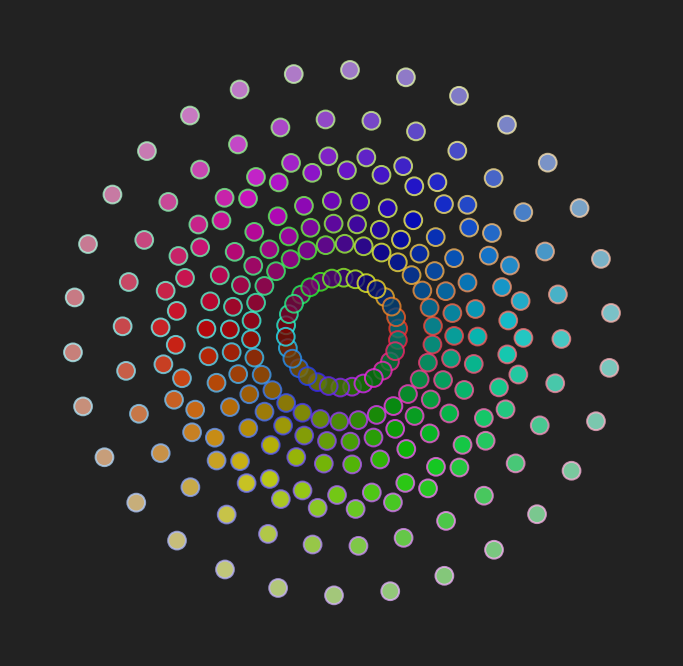

In [81]:
sks = vector_to_skew_matrix(
    interesting_perspectives[0]["final_vector"], 
    8
)
rmat = scipy.linalg.expm(sks)
u = np.dot(e8_root, rmat)
trajectories = [([u[i, 0]], [u[i, 1]]) for i in range(len(u))]

fig, ax = plt.subplots(figsize=(12, 12))
fig.set_facecolor("#222222")
ax.axis("off")

rt2 = np.sqrt(2)
ax.set_xlim(-rt2, rt2)
ax.set_ylim(-rt2, rt2)

u01 = (u+rt2)/(2*rt2)

ec = EllipseCollection(
    0.075*np.ones(240),
    0.075*np.ones(240),
    np.zeros(240),
    offsets=u[:, :2],
    units='x', 
    transOffset=ax.transData,
    linewidth=2,
    zorder=3,
)
ax.add_collection(ec)

ec.set_alpha(0.75)
ec.set_color(rgb_triplets)
ec.set_edgecolor(complements)

base_rot = scipy.linalg.expm(vector_to_skew_matrix(base_vec, 8))

def updater(frame):
    if frame % 500 == 0:
        print(frame)
    
    cvec = skew_vec_interper(frame/(total_frames-1))
    sks = vector_to_skew_matrix(cvec, 8)
    rmat = np.dot(
        base_rot,
        scipy.linalg.expm(sks)
    )
    u = np.dot(e8_root, rmat)
    
    for i, (xpt, ypt) in enumerate(zip(u[:, 0], u[:, 1])):
        xl, yl = trajectories[i]
        xl.append(xpt)
        yl.append(ypt)
    
    u01 = (u+rt2)/(2*rt2)
    
    ec.set_offsets(u[:, :2])
    
    return [ec, fig.patch]

FuncAnimation(
    fig = fig,
    func = updater,
    frames=range(total_frames),
    blit=True,
).save("../files/videos/e8_test.mp4", fps=frames_per_second, savefig_kwargs={'facecolor':'#222222'})

In [100]:
%%HTML
<video controls>
  <source src="../videos/e8_test.mp4" type="video/mp4">
</video>

# Trajectories

The trajectories traced out by the points are interesting and we can also visualize the trails that the points leave behind. Although I prefer the visually cleaner animation above to the one below there is something very ineteresting about being able to see the trajectory traces. 

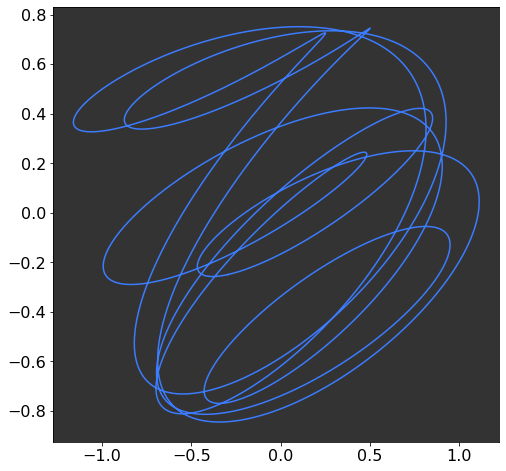

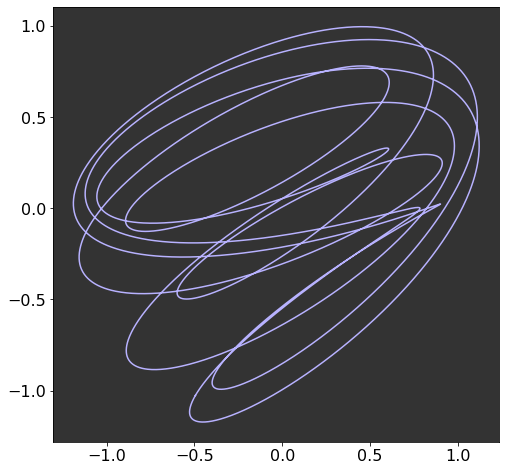

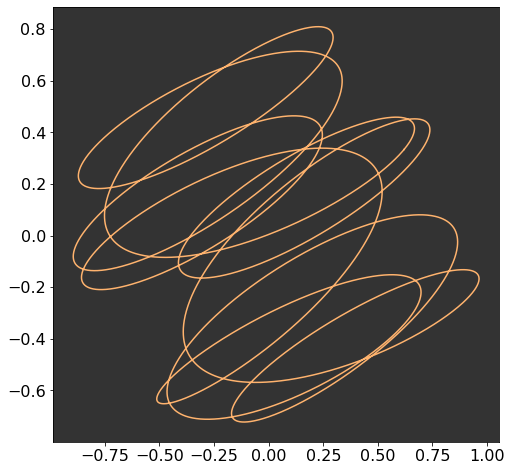

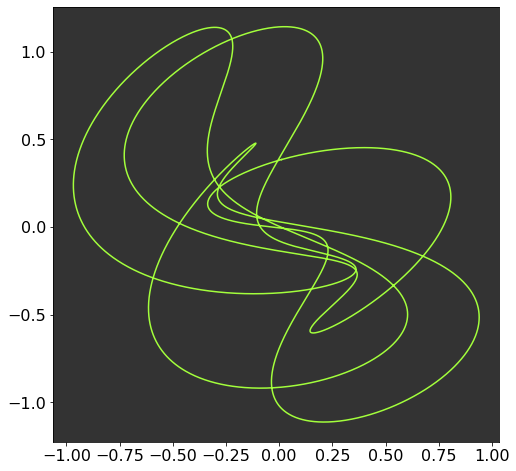

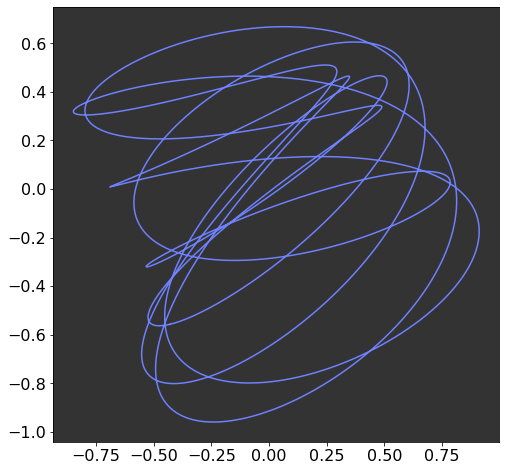

In [96]:
for i in np.arange(5):
    fig, ax = plt.subplots()
    ax.patch.set_facecolor("#333333")
    xl, yl = trajectories[i]
    plt.plot(xl, yl, color=complements[i])
    plt.show()

0
0
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500


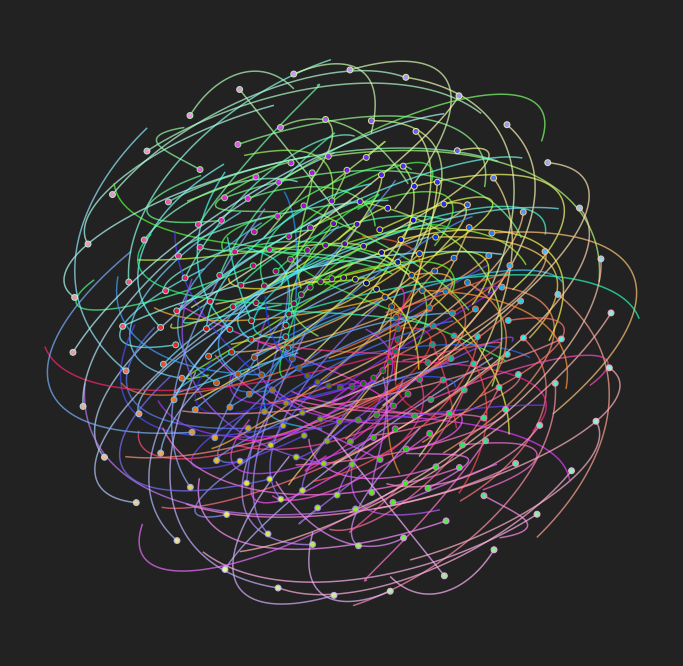

In [98]:
sks = vector_to_skew_matrix(
    interesting_perspectives[0]["final_vector"], 
    8
)
rmat = scipy.linalg.expm(sks)
u = np.dot(e8_root, rmat)
trajectories = [([u[i, 0]], [u[i, 1]]) for i in range(len(u))]

fig, ax = plt.subplots(figsize=(12, 12))
fig.set_facecolor("#222222")
ax.axis("off")

trajectory_plots = []

for i in range(len(u)):
    x_traj, y_traj = trajectories[i]
    cline ,= plt.plot(x_traj, y_traj, color=complements[i], alpha=0.7, linewidth=1.5)
    trajectory_plots.append(cline)

rt2 = np.sqrt(2)
ax.set_xlim(-rt2, rt2)
ax.set_ylim(-rt2, rt2)

u01 = (u+rt2)/(2*rt2)

ec = EllipseCollection(
    0.025*np.ones(240),
    0.025*np.ones(240),
    np.zeros(240),
    offsets=u[:, :2],
    units='x', 
    transOffset=ax.transData,
    linewidth=1,
    zorder=3,
    alpha=0.9,
)
ax.add_collection(ec)

line_plots = []

ec.set_color(rgb_triplets)
ec.set_edgecolor(complements)

base_rot = scipy.linalg.expm(vector_to_skew_matrix(base_vec, 8))

def updater(frame):
    if frame % 500 == 0:
        print(frame)
    
    cvec = skew_vec_interper(frame/(total_frames-1))
    sks = vector_to_skew_matrix(cvec, 8)
    rmat = np.dot(
        base_rot,
        scipy.linalg.expm(sks)
    )
    u = np.dot(e8_root, rmat)
    
    for i, (xpt, ypt) in enumerate(zip(u[:, 0], u[:, 1])):
        xl, yl = trajectories[i]
        xl.append(xpt)
        yl.append(ypt)
        trajectory_plots[i].set_xdata(xl[-200:])
        trajectory_plots[i].set_ydata(yl[-200:])
    
    u01 = (u+rt2)/(2*rt2)
    
    ec.set_offsets(u[:, :2])
    
    return [ec, fig.patch] + trajectory_plots

FuncAnimation(
    fig = fig,
    func = updater,
    frames=range(total_frames),
    blit=True,
).save("../files/videos/e8_trajectories.mp4", fps=frames_per_second, savefig_kwargs={'facecolor':'#222222'})

In [101]:
%%HTML
<video controls>
  <source src="../videos/e8_trajectories.mp4" type="video/mp4">
</video>